In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from data_loaders import get_multivariate_dataloader

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
INPUT_TENSORS_FILEPATH = "data/input_tensors.pt"
WS_OUTPUT_TENSORS_FILEPATH = "data/WS_output_tensors.pt"
BATCH_SIZE = 64

In [4]:
#TODO split in training and test sets
train_dataloader = get_multivariate_dataloader(INPUT_TENSORS_FILEPATH, WS_OUTPUT_TENSORS_FILEPATH, BATCH_SIZE)
len(train_dataloader)

6233 6233


98

### Multivariate regression to predict the wind speed field

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

#TODO
INPUT_SPACE = 3
OUTPUT_SPACE = 5120

EPOCHS = 500

print(INPUT_SPACE, OUTPUT_SPACE)

3 5120


In [ ]:
model = nn.Sequential(
    nn.Linear(INPUT_SPACE, 50),
    nn.ReLU(),
    nn.Linear(50, 500),
    nn.ReLU(),
    nn.Linear(500, OUTPUT_SPACE),
    nn.ReLU() #TODO?
).to(DEVICE)

def MSE(y_predicted:torch.Tensor, y_target:torch.Tensor):
    """
    Returns a single value tensor with 
    the mean of squared errors (SSE) between the predicted and target
    values:
    
    """
    error = y_predicted - y_target # element-wise substraction
    return torch.sum(error**2 ) / error.numel() # mean (sum/n)

def mean_speed_error(y_predicted:torch.Tensor, y_target:torch.Tensor):
    error = y_predicted - y_target
    return torch.mean(error, 1)

lr = 0.000001
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=lr
)
model.train()

print("Starting training")
epoch_to_loss_acc = dict()
max_accuracy = 0
for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accs = torch.FloatTensor()
    for batch in iter(train_dataloader):
        #TODO to device in the dataloader
        input_features, WS_eff_output = batch

        prediction = model.forward(input_features)

        # loss and step
        loss = MSE(prediction, WS_eff_output)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # TODO
        optimizer.step()

        epoch_loss += loss.item()

        #TODO accuracy or other metric computation
        acc = mean_speed_error(prediction, WS_eff_output)
        epoch_accs = torch.cat((epoch_accs, acc))

    epoch_acc = torch.mean(epoch_accs).item()
    print(f"{epoch=} -> {epoch_loss=}\t{epoch_acc=}")
    epoch_to_loss_acc[epoch] = [epoch_loss, epoch_acc]

#epoch_to_loss_acc

<AxesSubplot: xlabel='Epoch'>

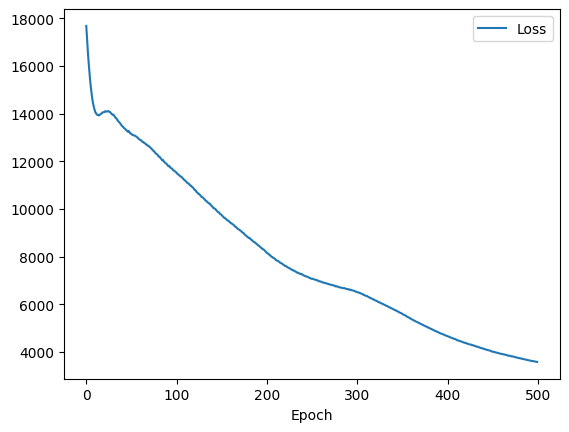

In [ ]:
metrics_df = pd.DataFrame(epoch_to_loss_acc).transpose().reset_index().rename(columns={"index": "Epoch", 0: "Loss", 1: "Speed avg error in wake prediction"})
metrics_df.plot(x="Epoch", y="Loss")

<AxesSubplot: xlabel='Epoch'>

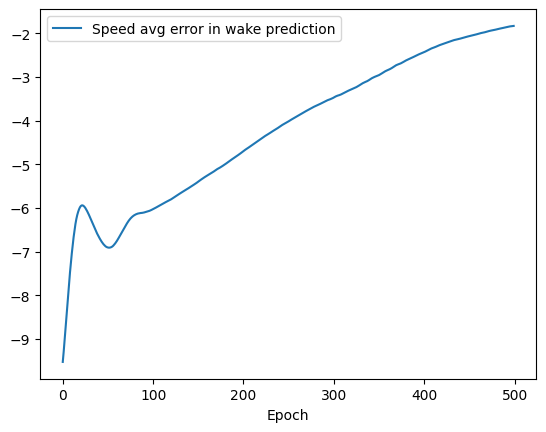

In [ ]:
metrics_df.plot(x="Epoch", y="Speed avg error in wake prediction")